# 测试训练好的超分辨率模型

本notebook用于测试训练好的patch-based 8×超分辨率模型。

## 测试流程

1. 生成新的测试数据对：256×256 LR → 4096×4096 HR
2. 加载训练好的8×超分辨率模型
3. 使用滑动窗口将256×256图像超分辨率到2048×2048
4. 再用bicubic插值从2048×2048放大到4096×4096
5. 对比模型输出与真实4096×4096 HR图像
6. 计算评估指标(PSNR, SSIM)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

## 1. 定义模型架构

必须与训练时使用的模型架构完全一致

In [2]:
class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch, ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch, ch, 3, padding=1)
        )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(x + self.conv(x))


class TinyUNet8x(nn.Module):
    """超轻量8×SR模型 (64×64 → 512×512)"""
    def __init__(self, base_ch=24):
        super().__init__()
        
        # 编码器 (64 → 32 → 16)
        self.inc = nn.Sequential(
            nn.Conv2d(3, base_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.down1 = nn.Sequential(
            nn.Conv2d(base_ch, base_ch*2, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            ResBlock(base_ch*2)
        )
        
        self.down2 = nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch*4, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            ResBlock(base_ch*4)
        )
        
        # 上采样到8× (16 → 32 → 64 → 128 → 256 → 512)
        self.up_blocks = nn.ModuleList([
            self._make_up(base_ch*4, base_ch*2),  # 16→32
            self._make_up(base_ch*2, base_ch),    # 32→64
            self._make_up(base_ch, base_ch),      # 64→128
            self._make_up(base_ch, base_ch),      # 128→256
            self._make_up(base_ch, base_ch),      # 256→512
        ])
        
        self.outc = nn.Conv2d(base_ch, 3, 1)
    
    def _make_up(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = self.down2(x)
        
        for up in self.up_blocks:
            x = up(x)
        
        return self.outc(x)

## 2. 加载训练好的模型

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

# 加载最佳模型
checkpoint_path = './checkpoints_debug/best_model.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

# 创建模型并加载权重
model = TinyUNet8x(base_ch=24).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"\n模型加载成功！")
print(f"训练epoch: {checkpoint['epoch']}")
print(f"验证损失: {checkpoint['val_loss']:.6f}")
print(f"模型参数: {sum(p.numel() for p in model.parameters()):,}")

使用设备: cpu

模型加载成功！
训练epoch: 30
验证损失: 0.010361
模型参数: 327,915


## 3. 生成测试数据

使用与训练数据相同的生成方法创建新的测试样本

In [4]:
def generate_circle(size=4096):
    """生成圆形"""
    img = np.zeros((size, size, 3), dtype=np.uint8)
    center = (size // 2, size // 2)
    radius = np.random.randint(size // 6, size // 3)
    color = tuple(np.random.randint(100, 255, 3).tolist())
    cv2.circle(img, center, radius, color, -1)
    return img

def generate_rectangle(size=4096):
    """生成矩形"""
    img = np.zeros((size, size, 3), dtype=np.uint8)
    w = np.random.randint(size // 4, size // 2)
    h = np.random.randint(size // 4, size // 2)
    x = np.random.randint(size // 6, size - w - size // 6)
    y = np.random.randint(size // 6, size - h - size // 6)
    color = tuple(np.random.randint(100, 255, 3).tolist())
    cv2.rectangle(img, (x, y), (x + w, y + h), color, -1)
    return img

def generate_triangle(size=4096):
    """生成三角形"""
    img = np.zeros((size, size, 3), dtype=np.uint8)
    pts = np.array([
        [size // 2, size // 4],
        [size // 4, 3 * size // 4],
        [3 * size // 4, 3 * size // 4]
    ], np.int32)
    offset = np.random.randint(-size // 8, size // 8, pts.shape)
    pts = pts + offset
    pts = pts.reshape((-1, 1, 2))
    color = tuple(np.random.randint(100, 255, 3).tolist())
    cv2.fillPoly(img, [pts], color)
    return img

def generate_multi_shapes(size=4096):
    """生成多个形状的组合"""
    img = np.zeros((size, size, 3), dtype=np.uint8)
    num_shapes = np.random.randint(2, 4)
    
    for _ in range(num_shapes):
        shape_type = np.random.choice(['circle', 'rectangle', 'triangle'])
        if shape_type == 'circle':
            center = (np.random.randint(size // 4, 3 * size // 4), 
                     np.random.randint(size // 4, 3 * size // 4))
            radius = np.random.randint(size // 12, size // 6)
            color = tuple(np.random.randint(50, 255, 3).tolist())
            cv2.circle(img, center, radius, color, -1)
        elif shape_type == 'rectangle':
            w = np.random.randint(size // 8, size // 4)
            h = np.random.randint(size // 8, size // 4)
            x = np.random.randint(size // 8, size - w - size // 8)
            y = np.random.randint(size // 8, size - h - size // 8)
            color = tuple(np.random.randint(50, 255, 3).tolist())
            cv2.rectangle(img, (x, y), (x + w, y + h), color, -1)
        else:
            cx = np.random.randint(size // 4, 3 * size // 4)
            cy = np.random.randint(size // 4, 3 * size // 4)
            s = np.random.randint(size // 12, size // 6)
            pts = np.array([[cx, cy - s], [cx - s, cy + s], [cx + s, cy + s]], np.int32)
            pts = pts.reshape((-1, 1, 2))
            color = tuple(np.random.randint(50, 255, 3).tolist())
            cv2.fillPoly(img, [pts], color)
    
    return img

def downscale_image(img, target_size):
    """降采样图像"""
    return cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_CUBIC)

## 4. 创建测试样本

生成几对256×256 LR和4096×4096 HR的测试图像

In [5]:
# 生成测试数据
generators = [generate_circle, generate_rectangle, generate_triangle, generate_multi_shapes]
num_tests = 5

test_data = []
for i in range(num_tests):
    generator = np.random.choice(generators)
    hr_img = generator(size=4096)  # 生成4096x4096的高分辨率图像
    lr_img = downscale_image(hr_img, 256)  # 下采样到256x256
    test_data.append((lr_img, hr_img))

print(f"已生成 {num_tests} 个测试样本")
print(f"LR尺寸: 256×256")
print(f"HR尺寸: 4096×4096")

已生成 5 个测试样本
LR尺寸: 256×256
HR尺寸: 4096×4096


## 5. 模型推理（滑动窗口）

使用滑动窗口策略将256×256图像超分辨率到4096×4096：
1. 将256×256切分成4×4=16个64×64的patches
2. 每个patch通过8×模型得到512×512
3. 拼接成2048×2048
4. Bicubic插值放大到4096×4096

In [6]:
def inference_patch(model, lr_patch, device):
    """对单个64×64 patch进行8×超分辨率推理，输出512×512"""
    lr_tensor = torch.from_numpy(lr_patch.transpose(2, 0, 1)).float() / 255.0
    lr_tensor = lr_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        sr_tensor = model(lr_tensor)
    
    sr_patch = sr_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    sr_patch = np.clip(sr_patch * 255.0, 0, 255).astype(np.uint8)
    
    return sr_patch

def inference_full_image(model, lr_img_256, device):
    """
    使用滑动窗口将256×256图像超分辨率到4096×4096
    
    步骤：
    1. 256×256 → 切分成4×4=16个64×64 patches
    2. 每个patch → 8×模型 → 512×512
    3. 拼接成2048×2048
    4. Bicubic插值 → 4096×4096
    """
    patch_size = 64
    sr_patch_size = 512
    num_patches = 4  # 256 // 64 = 4
    
    # 创建2048×2048的输出画布
    sr_img_2048 = np.zeros((2048, 2048, 3), dtype=np.uint8)
    
    # 滑动窗口处理
    for i in range(num_patches):
        for j in range(num_patches):
            # 提取64×64的LR patch
            y_start = i * patch_size
            x_start = j * patch_size
            lr_patch = lr_img_256[y_start:y_start+patch_size, x_start:x_start+patch_size]
            
            # 8×超分辨率 → 512×512
            sr_patch = inference_patch(model, lr_patch, device)
            
            # 放入2048×2048画布
            y_sr = i * sr_patch_size
            x_sr = j * sr_patch_size
            sr_img_2048[y_sr:y_sr+sr_patch_size, x_sr:x_sr+sr_patch_size] = sr_patch
    
    # 最后用Bicubic插值从2048×2048放大到4096×4096
    sr_img_4096 = cv2.resize(sr_img_2048, (4096, 4096), interpolation=cv2.INTER_CUBIC)
    
    return sr_img_4096

# 对所有测试样本进行推理
results = []
for i, (lr_img, hr_img) in enumerate(test_data):
    print(f"处理样本 {i+1}/{num_tests}...")
    sr_img = inference_full_image(model, lr_img, device)
    results.append((lr_img, hr_img, sr_img))
    print(f"  完成: 256×256 → 4096×4096")

print("\n推理完成！")

处理样本 1/5...
  完成: 256×256 → 4096×4096
处理样本 2/5...
  完成: 256×256 → 4096×4096
处理样本 3/5...
  完成: 256×256 → 4096×4096
处理样本 4/5...
  完成: 256×256 → 4096×4096
处理样本 5/5...
  完成: 256×256 → 4096×4096

推理完成！


## 6. 计算评估指标

计算PSNR和SSIM来评估模型性能

In [7]:
# 计算每个样本的指标
psnr_values = []
ssim_values = []

print("\n=== 评估指标 ===")
print("样本\tPSNR (dB)\tSSIM")
print("-" * 40)

for i, (lr_img, hr_img, sr_img) in enumerate(results):
    # 计算PSNR
    psnr_val = psnr(hr_img, sr_img)
    psnr_values.append(psnr_val)
    
    # 计算SSIM
    ssim_val = ssim(hr_img, sr_img, channel_axis=2, data_range=255)
    ssim_values.append(ssim_val)
    
    print(f"{i+1}\t{psnr_val:.2f}\t\t{ssim_val:.4f}")

print("-" * 40)
print(f"平均\t{np.mean(psnr_values):.2f}\t\t{np.mean(ssim_values):.4f}")


=== 评估指标 ===
样本	PSNR (dB)	SSIM
----------------------------------------
1	24.46		0.9907
2	25.92		0.9904
3	28.42		0.9918
4	22.04		0.9729
5	28.47		0.9868
----------------------------------------
平均	25.86		0.9865


## 7. 可视化结果

对比显示：256×256 LR输入、4096×4096 SR输出、4096×4096 HR真值
（为了显示，会下采样到1024×1024）

/var/folders/6t/fh8mypp111l_9srnsmjvv_hh0000gn/T/ipykernel_76689/3005730591.py:22: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6t/fh8mypp111l_9srnsmjvv_hh0000gn/T/ipykernel_76689/3005730591.py:22: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6t/fh8mypp111l_9srnsmjvv_hh0000gn/T/ipykernel_76689/3005730591.py:22: UserWarning: Glyph 36755 (\N{CJK UNIFIED IDEOGRAPH-8F93}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6t/fh8mypp111l_9srnsmjvv_hh0000gn/T/ipykernel_76689/3005730591.py:22: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6t/fh8mypp111l_9srnsmjvv_hh0000gn/T/ipykernel_76689/3005730591.py:22: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6t/fh8m

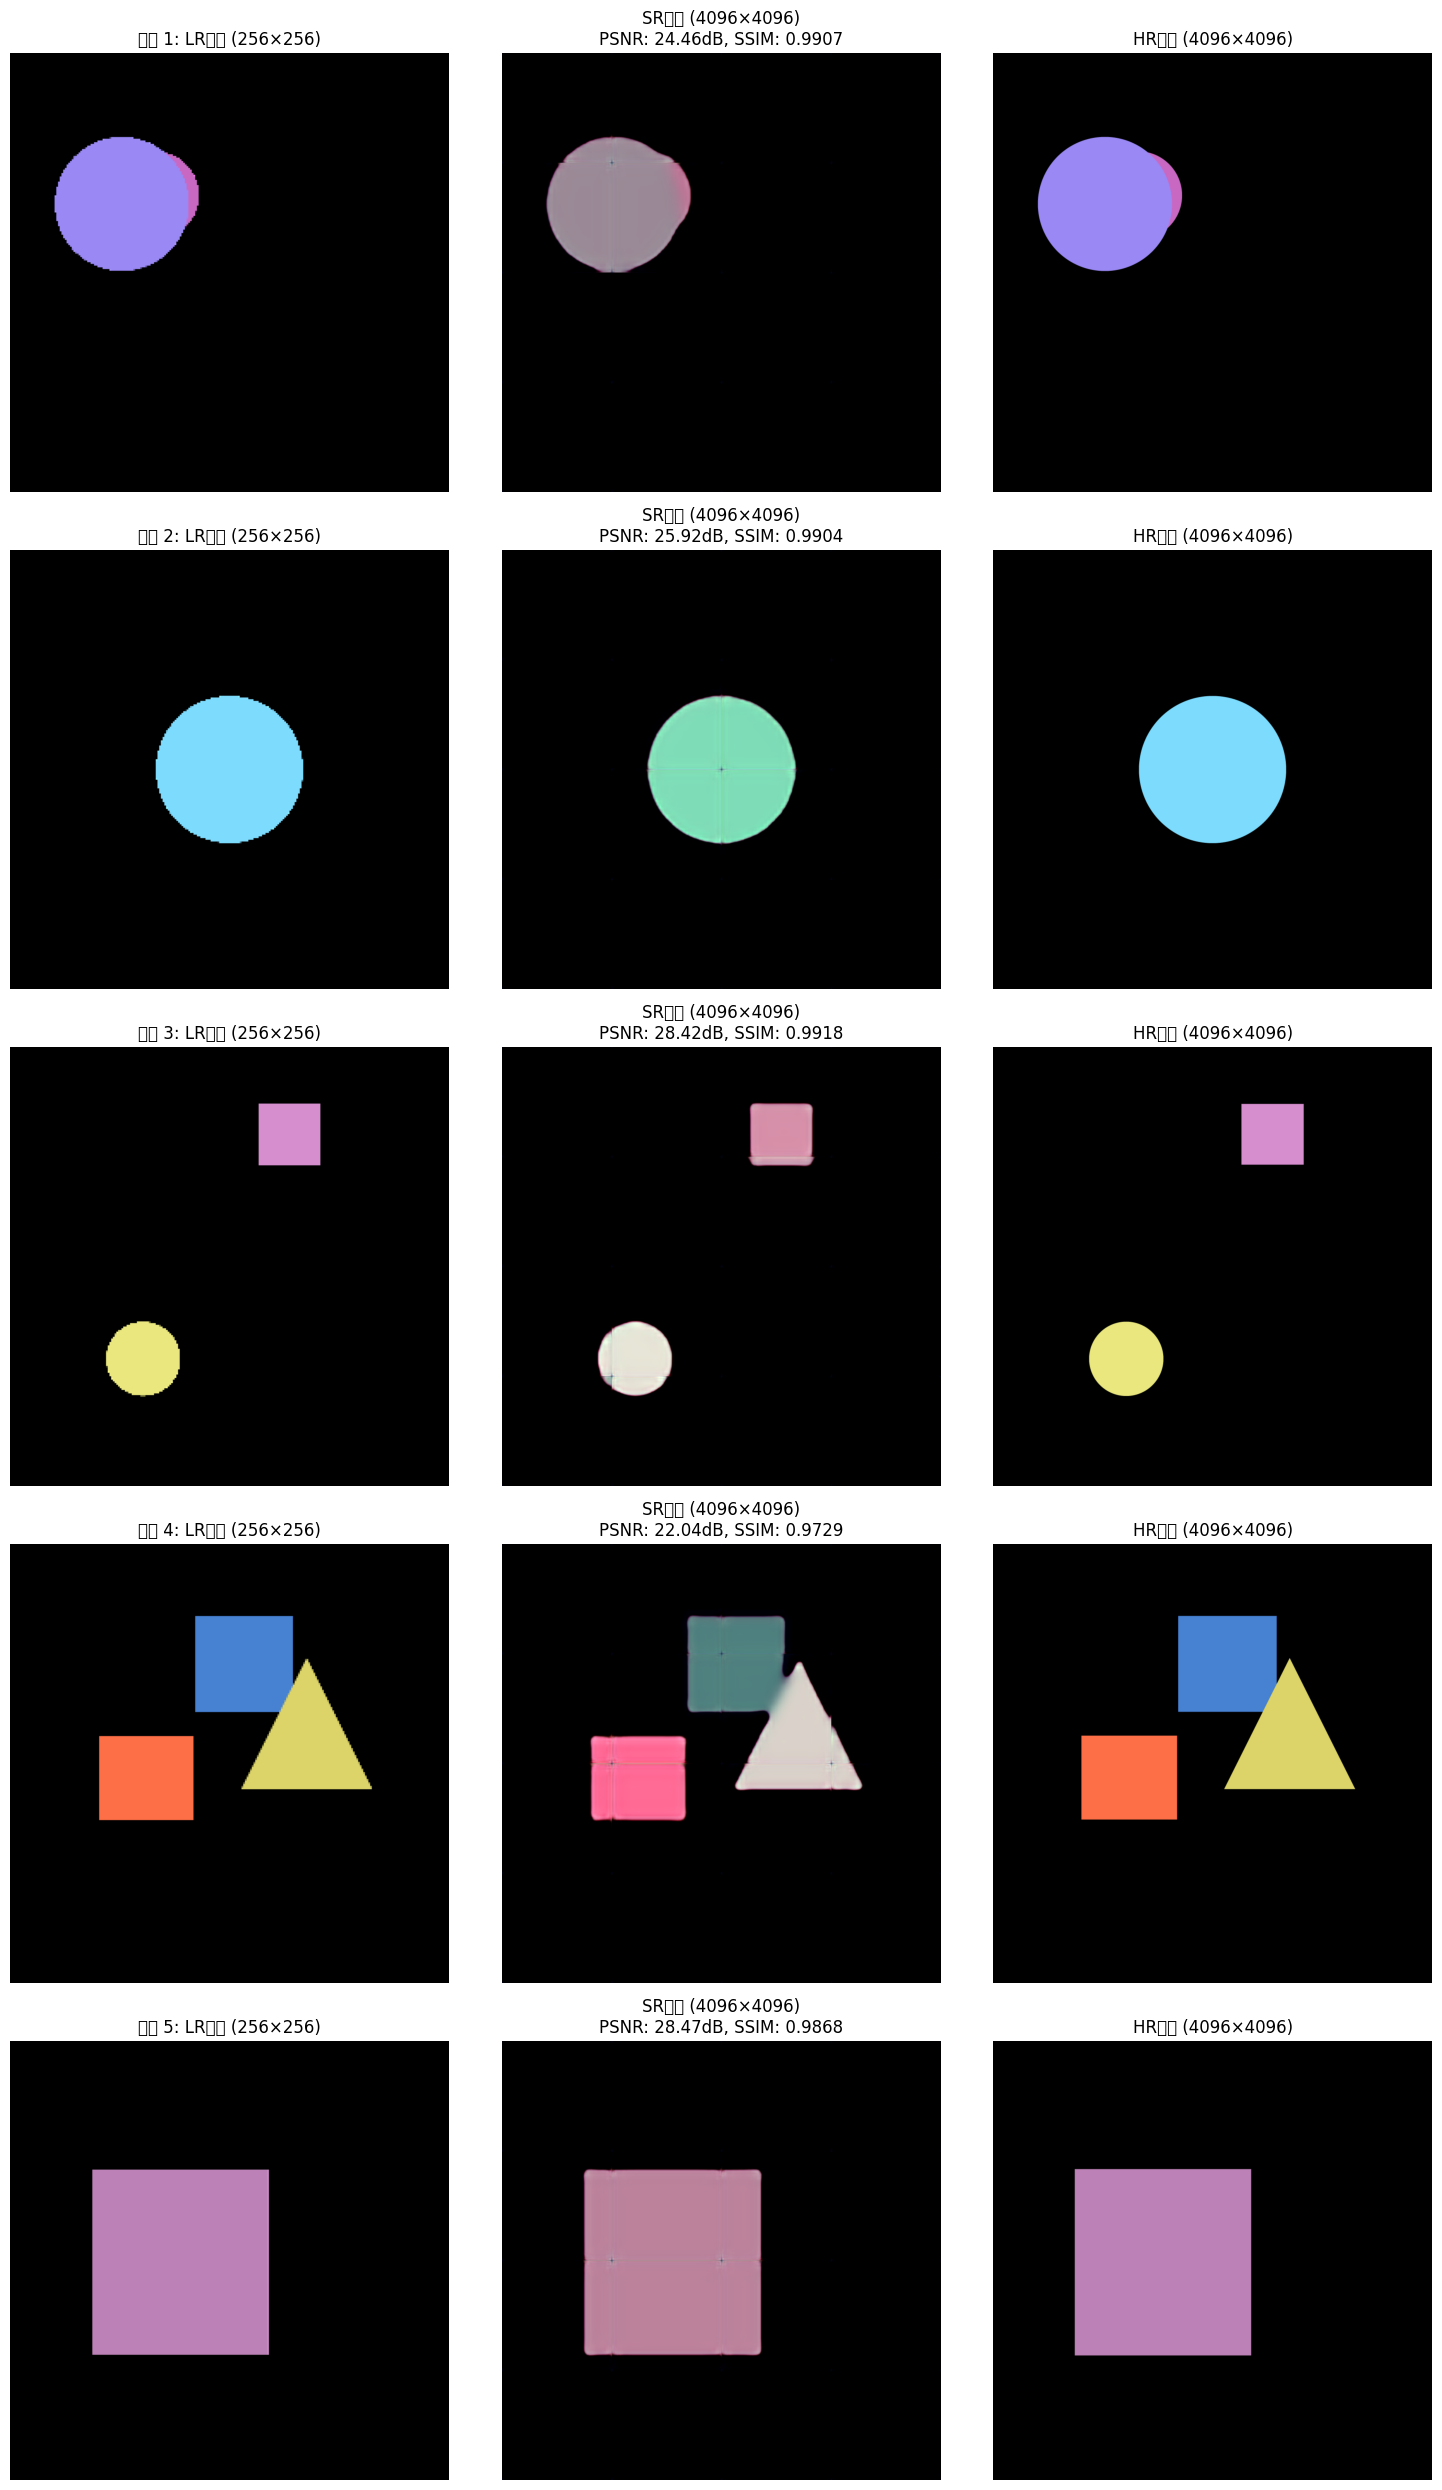

In [8]:
# 可视化所有测试结果（下采样到1024×1024以便显示）
fig, axes = plt.subplots(num_tests, 3, figsize=(15, 5*num_tests))

for i, (lr_img, hr_img, sr_img) in enumerate(results):
    # 低分辨率输入
    axes[i, 0].imshow(cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title(f'样本 {i+1}: LR输入 (256×256)')
    axes[i, 0].axis('off')
    
    # 模型输出（下采样显示）
    sr_display = cv2.resize(sr_img, (1024, 1024), interpolation=cv2.INTER_AREA)
    axes[i, 1].imshow(cv2.cvtColor(sr_display, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title(f'SR输出 (4096×4096)\nPSNR: {psnr_values[i]:.2f}dB, SSIM: {ssim_values[i]:.4f}')
    axes[i, 1].axis('off')
    
    # 真实高分辨率（下采样显示）
    hr_display = cv2.resize(hr_img, (1024, 1024), interpolation=cv2.INTER_AREA)
    axes[i, 2].imshow(cv2.cvtColor(hr_display, cv2.COLOR_BGR2RGB))
    axes[i, 2].set_title(f'HR真值 (4096×4096)')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

## 8. 与Bicubic插值对比

对比模型输出与传统Bicubic插值方法

In [9]:
# 使用Bicubic插值进行上采样
bicubic_results = []
bicubic_psnr = []
bicubic_ssim = []

print("\n=== 对比Bicubic插值 ===")
print("样本\t模型PSNR\tBicubic PSNR\t提升")
print("-" * 50)

for i, (lr_img, hr_img, sr_img) in enumerate(results):
    # Bicubic上采样 256×256 → 4096×4096
    bicubic_img = cv2.resize(lr_img, (4096, 4096), interpolation=cv2.INTER_CUBIC)
    bicubic_results.append(bicubic_img)
    
    # 计算Bicubic的指标
    b_psnr = psnr(hr_img, bicubic_img)
    b_ssim = ssim(hr_img, bicubic_img, channel_axis=2, data_range=255)
    bicubic_psnr.append(b_psnr)
    bicubic_ssim.append(b_ssim)
    
    improvement = psnr_values[i] - b_psnr
    print(f"{i+1}\t{psnr_values[i]:.2f}dB\t\t{b_psnr:.2f}dB\t\t+{improvement:.2f}dB")

print("-" * 50)
avg_improvement = np.mean(psnr_values) - np.mean(bicubic_psnr)
print(f"平均\t{np.mean(psnr_values):.2f}dB\t\t{np.mean(bicubic_psnr):.2f}dB\t\t+{avg_improvement:.2f}dB")


=== 对比Bicubic插值 ===
样本	模型PSNR	Bicubic PSNR	提升
--------------------------------------------------
1	24.46dB		35.83dB		+-11.36dB
2	25.92dB		34.58dB		+-8.66dB
3	28.42dB		34.49dB		+-6.07dB
4	22.04dB		32.22dB		+-10.17dB
5	28.47dB		31.63dB		+-3.15dB
--------------------------------------------------
平均	25.86dB		33.75dB		+-7.88dB


## 9. 详细对比可视化

并排对比模型输出、Bicubic插值和真实HR图像

/var/folders/6t/fh8mypp111l_9srnsmjvv_hh0000gn/T/ipykernel_76689/1917470549.py:32: UserWarning: Glyph 36755 (\N{CJK UNIFIED IDEOGRAPH-8F93}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6t/fh8mypp111l_9srnsmjvv_hh0000gn/T/ipykernel_76689/1917470549.py:32: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6t/fh8mypp111l_9srnsmjvv_hh0000gn/T/ipykernel_76689/1917470549.py:32: UserWarning: Glyph 25554 (\N{CJK UNIFIED IDEOGRAPH-63D2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6t/fh8mypp111l_9srnsmjvv_hh0000gn/T/ipykernel_76689/1917470549.py:32: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6t/fh8mypp111l_9srnsmjvv_hh0000gn/T/ipykernel_76689/1917470549.py:32: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/6t/fh8m

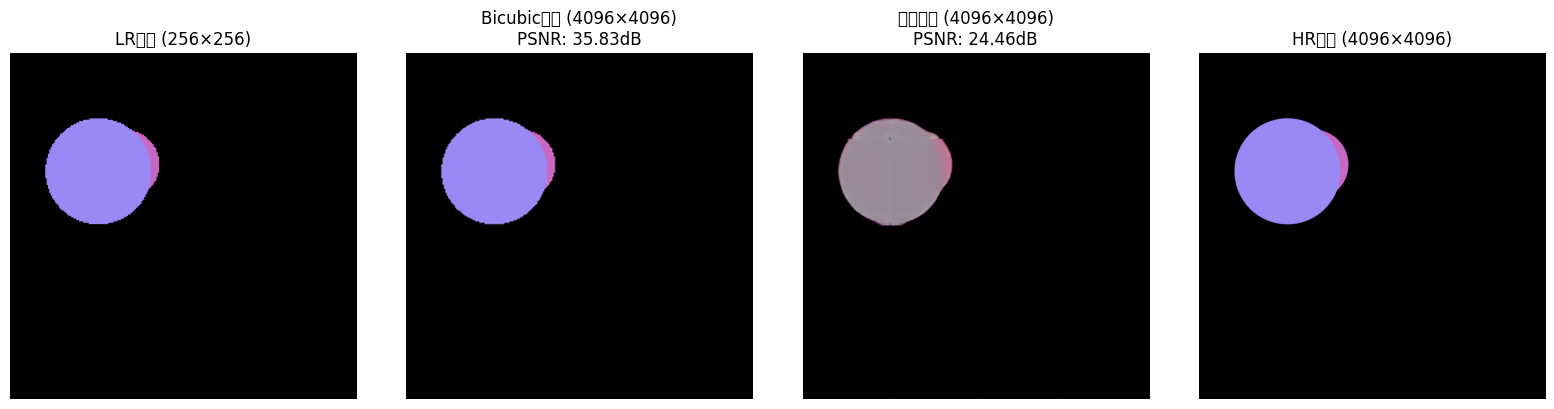

In [10]:
# 选择一个样本进行详细对比
sample_idx = 0

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

lr_img, hr_img, sr_img = results[sample_idx]
bicubic_img = bicubic_results[sample_idx]

# LR输入
axes[0].imshow(cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB))
axes[0].set_title('LR输入 (256×256)')
axes[0].axis('off')

# Bicubic上采样（下采样显示）
bicubic_display = cv2.resize(bicubic_img, (1024, 1024), interpolation=cv2.INTER_AREA)
axes[1].imshow(cv2.cvtColor(bicubic_display, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Bicubic插值 (4096×4096)\nPSNR: {bicubic_psnr[sample_idx]:.2f}dB')
axes[1].axis('off')

# 模型输出（下采样显示）
sr_display = cv2.resize(sr_img, (1024, 1024), interpolation=cv2.INTER_AREA)
axes[2].imshow(cv2.cvtColor(sr_display, cv2.COLOR_BGR2RGB))
axes[2].set_title(f'模型输出 (4096×4096)\nPSNR: {psnr_values[sample_idx]:.2f}dB')
axes[2].axis('off')

# HR真值（下采样显示）
hr_display = cv2.resize(hr_img, (1024, 1024), interpolation=cv2.INTER_AREA)
axes[3].imshow(cv2.cvtColor(hr_display, cv2.COLOR_BGR2RGB))
axes[3].set_title('HR真值 (4096×4096)')
axes[3].axis('off')

plt.tight_layout()
plt.show()

## 10. 测试总结

总结模型性能和测试结果

In [11]:
summary = f"""
{'='*60}
模型测试总结
{'='*60}

模型信息:
  检查点: {checkpoint_path}
  训练epoch: {checkpoint['epoch']}
  训练损失: {checkpoint['val_loss']:.6f}
  参数量: {sum(p.numel() for p in model.parameters()):,}

测试配置:
  测试样本数: {num_tests}
  输入尺寸: 256×256
  输出尺寸: 4096×4096
  总缩放倍数: 16× (8×模型 + 2×Bicubic)

性能指标:
  模型平均PSNR: {np.mean(psnr_values):.2f} dB
  模型平均SSIM: {np.mean(ssim_values):.4f}
  
  Bicubic平均PSNR: {np.mean(bicubic_psnr):.2f} dB
  Bicubic平均SSIM: {np.mean(bicubic_ssim):.4f}
  
  PSNR提升: +{np.mean(psnr_values) - np.mean(bicubic_psnr):.2f} dB
  SSIM提升: +{np.mean(ssim_values) - np.mean(bicubic_ssim):.4f}
{'='*60}
"""

print(summary)


模型测试总结

模型信息:
  检查点: ./checkpoints_debug/best_model.pth
  训练epoch: 30
  训练损失: 0.010361
  参数量: 327,915

测试配置:
  测试样本数: 5
  输入尺寸: 256×256
  输出尺寸: 4096×4096
  总缩放倍数: 16× (8×模型 + 2×Bicubic)

性能指标:
  模型平均PSNR: 25.86 dB
  模型平均SSIM: 0.9865

  Bicubic平均PSNR: 33.75 dB
  Bicubic平均SSIM: 0.9929

  PSNR提升: +-7.88 dB
  SSIM提升: +-0.0064

